<a href="https://colab.research.google.com/github/Aryan-kansal-19/YOLOv5_Object_Detection_on_Augumented_Dataset/blob/main/YOLOv5_Object_Detection_on_Augumented_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

/content/drive/MyDrive
Cloning into 'yolov5'...
remote: Enumerating objects: 12125, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 12125 (delta 0), reused 0 (delta 0), pack-reused 12122
Receiving objects: 100% (12125/12125), 11.92 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (8394/8394), done.


In [ ]:
%cd /content/drive/MyDrive/yolov5

/content/drive/MyDrive/yolov5


In [ ]:
import torch
from IPython.display import Image, display, Javascript  # for displaying images
import yaml
import glob
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
if torch.cuda.is_available():
  print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0))) 
else:
  print('CPU')

torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
%ls

CONTRIBUTING.md  LICENSE              requirements.txt  utils/
data/            models/              setup.cfg         valid/
data.yaml        __pycache__/         test/             val.py
detect.py        README.dataset.txt   train/
export.py        README.md            train.py
hubconf.py       README.roboflow.txt  tutorial.ipynb


In [ ]:

!curl -L "https://public.roboflow.com/ds/vytZ6a4szC?key=TMPoiDrIH1" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    951      0 --:--:-- --:--:-- --:--:--   951
100 6105k  100 6105k    0     0  3060k      0  0:00:01  0:00:01 --:--:-- 5831k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/18_jpg.rf.844374cc4cd6891417b131b55b40f3c5.jpg  
 extracting: test/images/24_jpg.rf.3b65330eeed9ca9e44ad71cd70f4e52a.jpg  
 extracting: test/images/26_jpg.rf.6aff383da39c46b4a65299ff73681f91.jpg  
 extracting: test/images/2_jpg.rf.34f196ef04b288c50b2b066e0cdf3dc8.jpg  
 extracting: test/images/IMG_6820_jpg.rf.f18338f170168084a6c1cd05c4274f21.jpg  
 extracting: test/images/PXL_20201103_181916758_jpg.rf.b52dd0fe46713fb8ad00cb1aff1140fb.jpg  
 extracting: test/images/PXL_2020

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/drive/MyDrive/yolov5/data.yaml

train: ../drive/MyDrive/yolov5/train/images
val: ../drive/MyDrive/yolov5/valid/images

nc: 1
names: ['package']

In [ ]:
# define number of classes based on YAML
with open("/content/drive/MyDrive/yolov5/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration predefined by the YOLO itself
%cat /content/drive/MyDrive/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 200 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/yolov5
!python train.py --img 416 --batch 8 --epochs 200 --data /content/drive/MyDrive/yolov5/data.yaml --cfg /content/drive/MyDrive/yolov5/models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/drive/MyDrive/yolov5
train: weights=, cfg=/content/drive/MyDrive/yolov5/models/custom_yolov5s.yaml, data=/content/drive/MyDrive/yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-235-g632559b Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, 

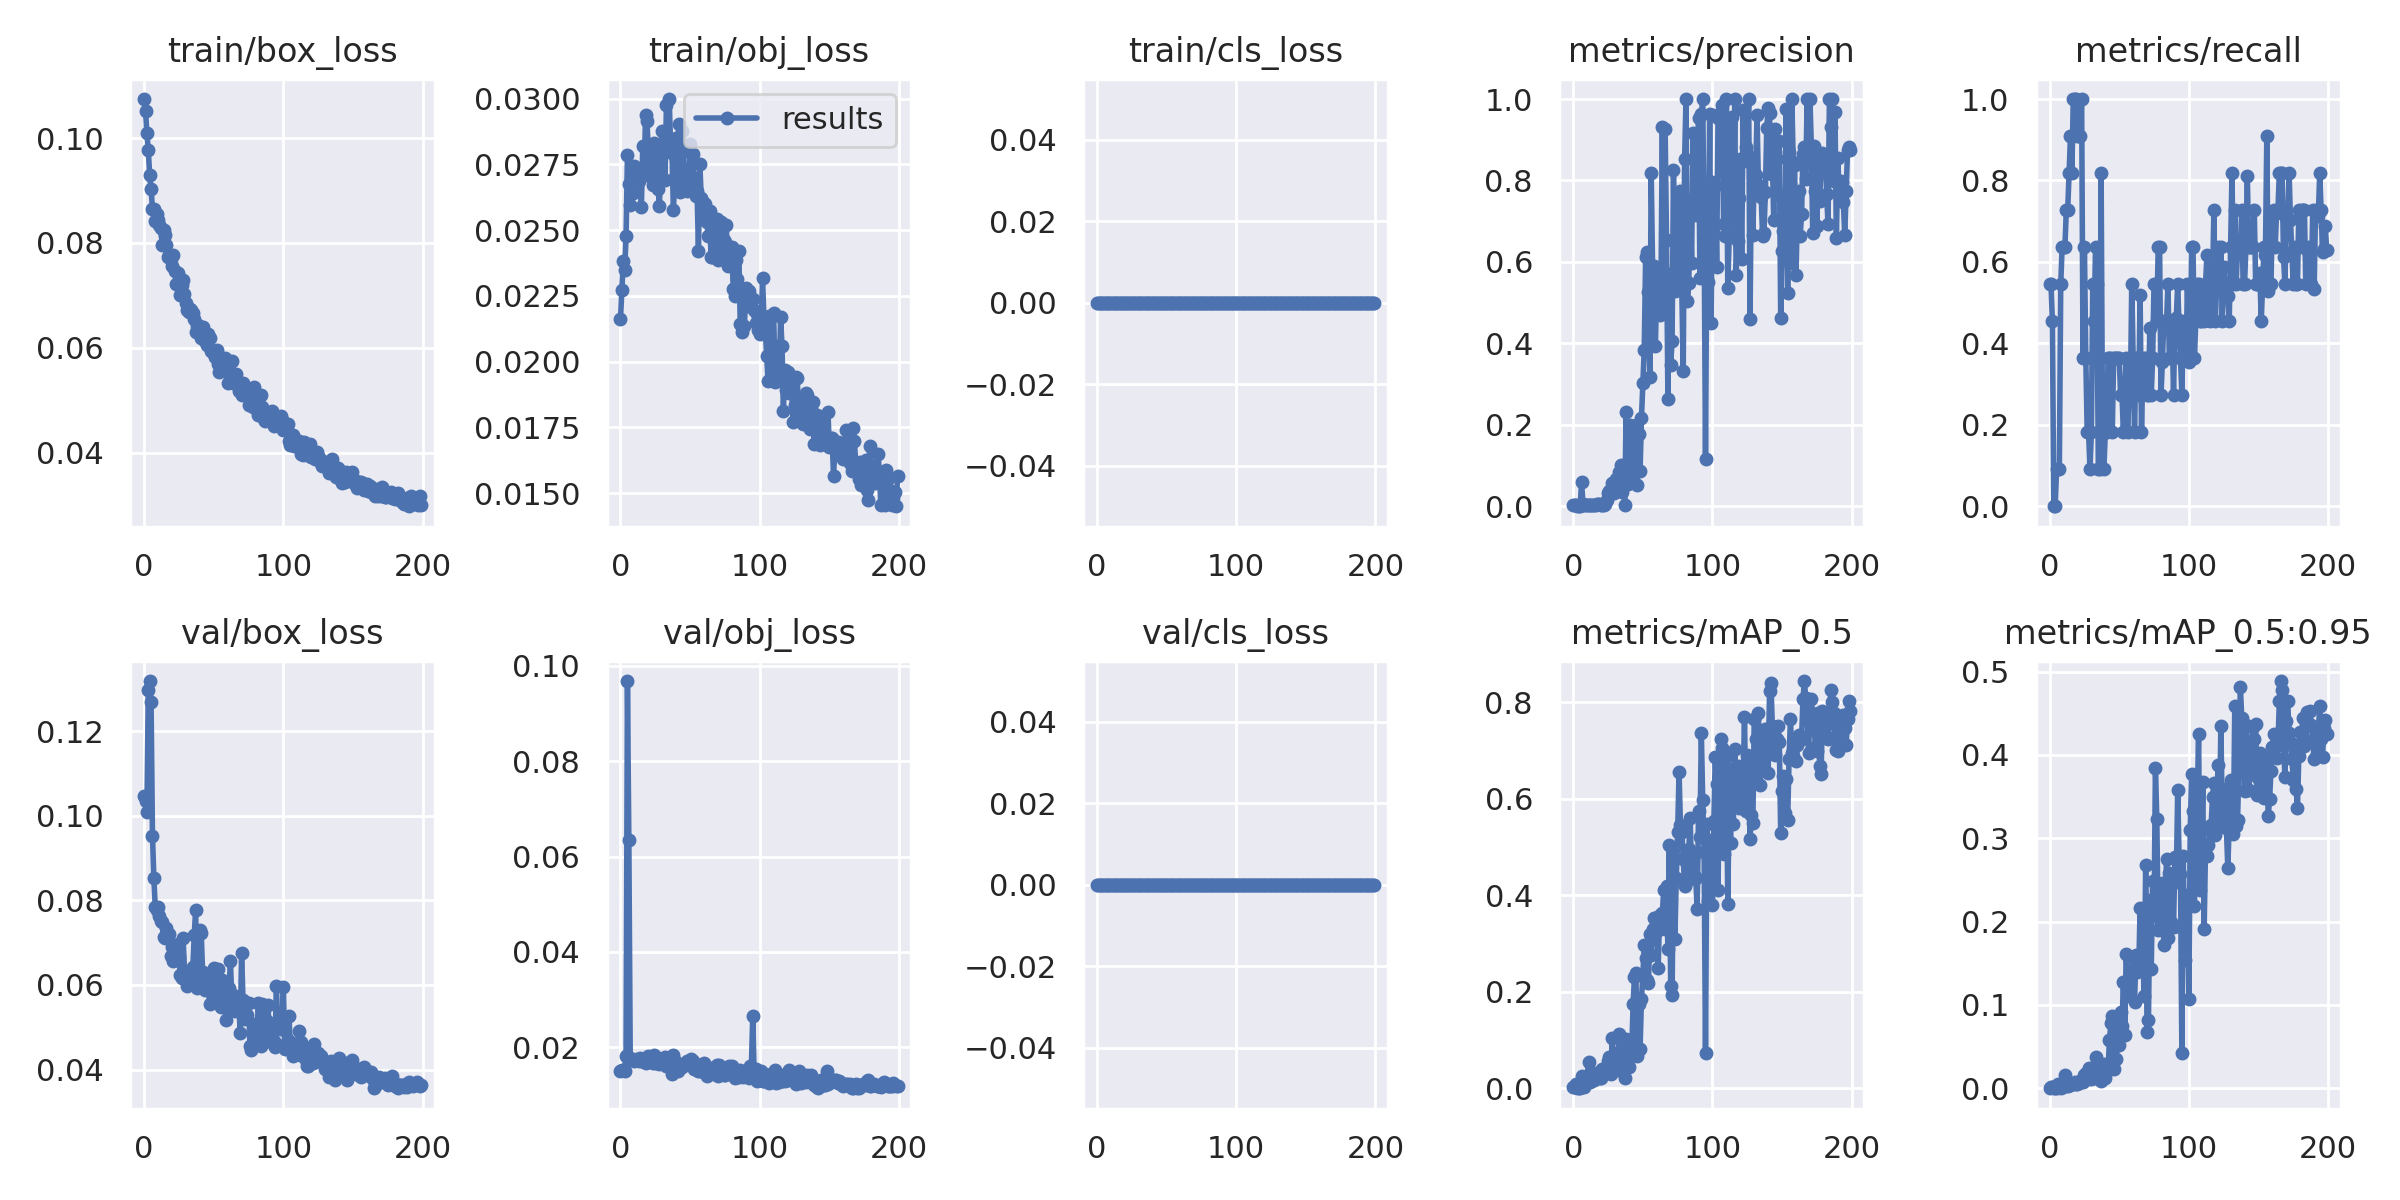

In [ ]:
Image(filename='/content/drive/MyDrive/yolov5/runs/train/yolov5s_results2/results.png', width=1000) # view results.png

GROUND TRUTH TRAINING DATA:


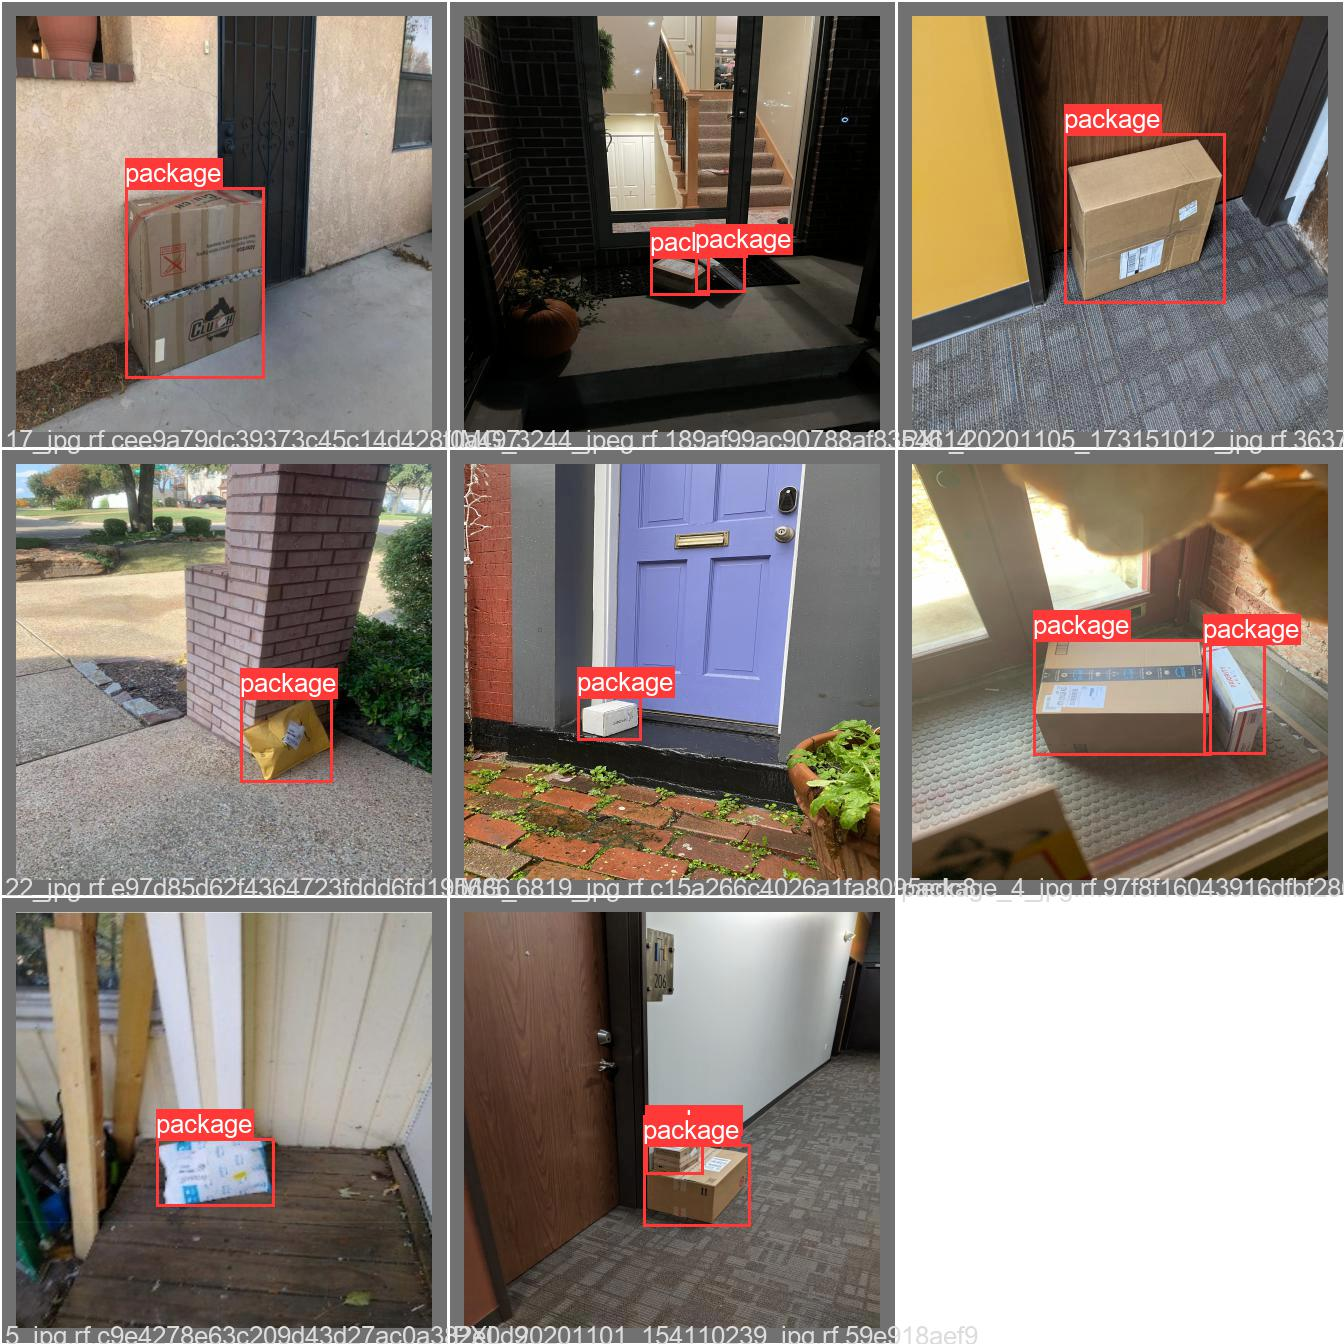

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


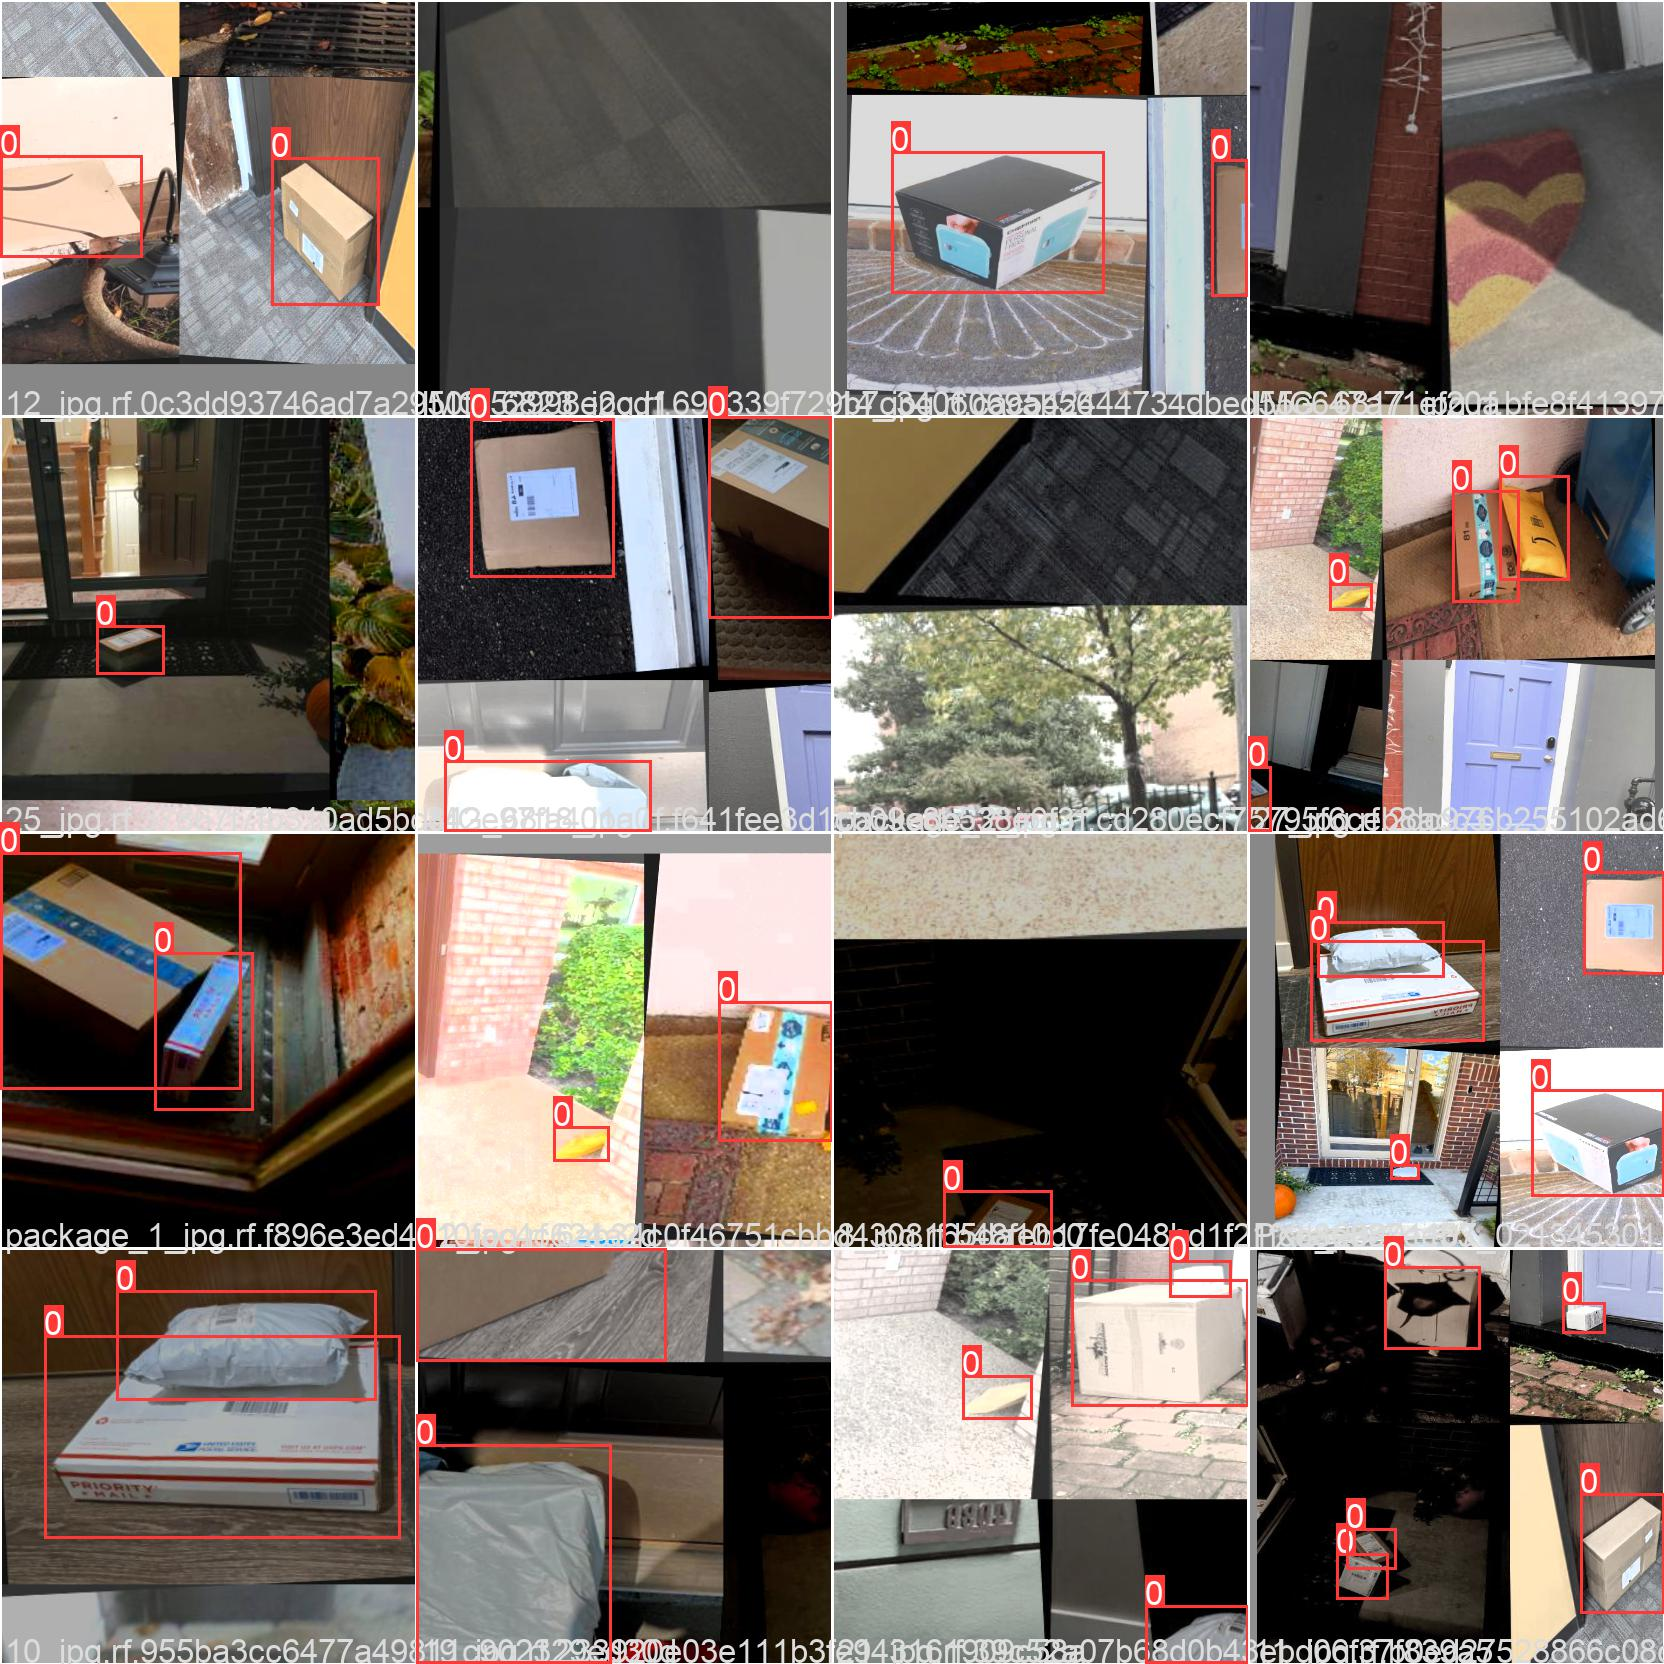

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results3/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .008 second inference time. That is 140 FPS on a TESLA T4!
# use the best weights!
%cd /content/drive/MyDrive/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ../yolov5/test/images

/content/drive/MyDrive/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=../yolov5/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-235-g632559b Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients
image 1/7 /content/drive/MyDrive/yolov5/test/images/18_jpg.rf.844374cc4cd6891417b131b55b40f3c5.jpg: 416x416 1 package, Done. (0.011s)
image 2/7 /content/drive/MyDrive/yolov5/test/images/24_jpg.rf.3b65330eeed9ca9e44ad71cd70f4e52a.jpg: 416x416 1 package, Done. (0.015s)
image 3/7 /content/drive/MyDrive/yolov5/test/images/

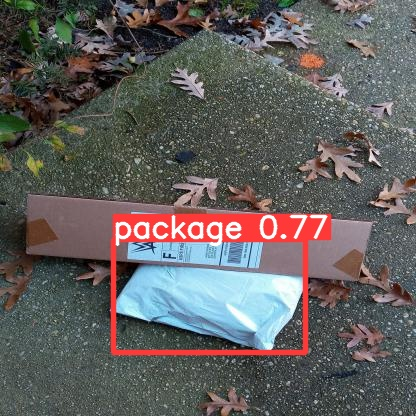

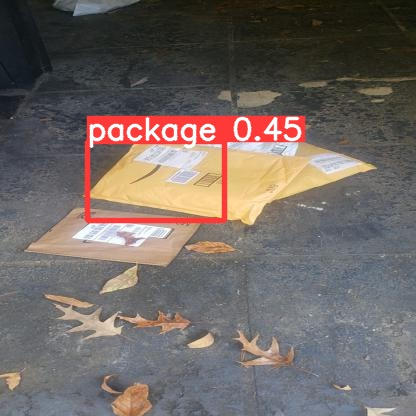

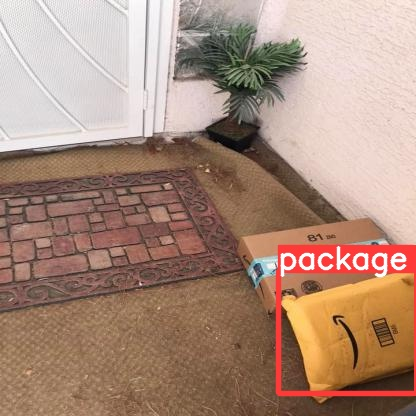

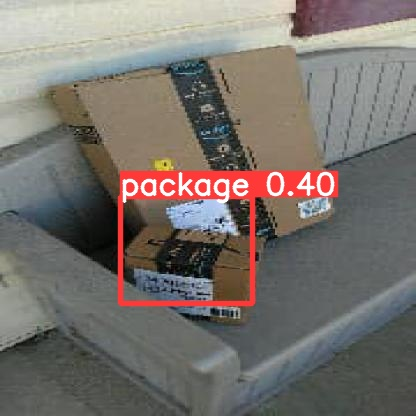

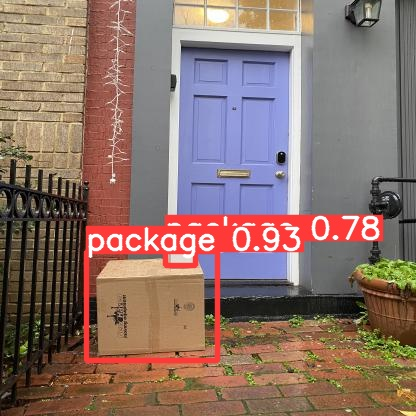

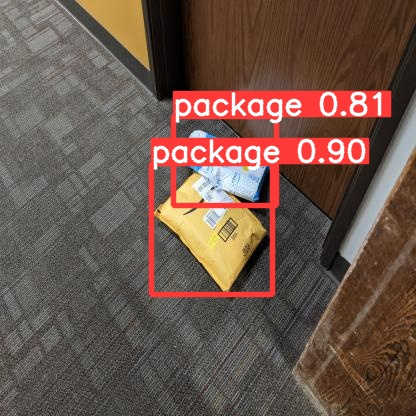

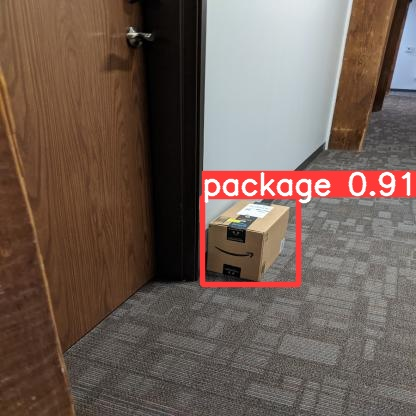

In [ ]:
for imageName in glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Package Detection In Real Time

In [ ]:
# when we ran this, we saw .008 second inference time. That is 140 FPS on a TESLA T4!
# use the best weights!
%cd /content/drive/MyDrive/yolov5/
%run detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source 0